In [1]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy import stats
import tensorboard as tb
from scipy.interpolate import make_interp_spline, BSpline
from tensorboard.backend.event_processing import event_accumulator
import math

def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

nImages = 50000
miniBatches = 128
nEpochs = 20
nRunsInEpoch = math.floor(nImages/miniBatches)
loss_sum = 0.0
def accumulated_loss(x):
    global loss_sum
    if x.step%nRunsInEpoch == 0:
        loss_sum = x.value
    loss_sum += x.value
    x.value = loss_sum
    return loss_sum

def manipulate_df(df):
    df_accuracy_at_epoch = df['Accuracy'].loc[df['Accuracy']['step']%nRunsInEpoch == 0]
    df_accuracy_at_epoch.loc[:,'Epoch'] = range(1,len(df_accuracy_at_epoch)+1)

    df_loss = df['LossEveryIter']
    df_loss.loc[:,'LossSum'] = df_loss.apply(lambda x : accumulated_loss(x),axis = 1)
    loss_sum = 0.0 # resetting loss
    df_loss_at_epoch = df_loss.loc[df_loss['step']%nRunsInEpoch == 0]
    df_loss_at_epoch.loc[:,'Epoch'] = range(1,len(df_loss_at_epoch)+1)

    df_validation_loss = df['ValidationLossEveryEpoch']
    df_validation_loss.loc[:,'Epoch'] = range(1,len(df_validation_loss)+1)

    df_validation_acc = df['ValidationAccuracyEveryEpoch']
    df_validation_acc.loc[:,'Epoch'] = range(1,len(df_validation_acc)+1)
    
    return {'Accuracy':df_accuracy_at_epoch,
            'Loss':df_loss_at_epoch, 
            'ValidationLossEveryEpoch':df_validation_loss,
            'ValidationAccuracyEveryEpoch' :df_validation_acc }


scalars = ['LossEveryIter', 'Accuracy','ValidationLossEveryEpoch','ValidationAccuracyEveryEpoch']

In [7]:
df_base_model = parse_tensorboard('../../../../cnn_training/base_model/train_28_08_2022/tensor_board_logs/events.out.tfevents.1661716842.bhagyasyam.7120.0', scalars)
df_batch_norm_model = parse_tensorboard('../../../../cnn_training/batch_norm/train_28_08_2022/tensor_board_logs/events.out.tfevents.1661721776.bhagyasyam.19276.0', scalars)
df_learn_decay_model = parse_tensorboard('../../../../cnn_training/learn_decay/train_28_08_2022/tensor_board_logs/events.out.tfevents.1661725362.bhagyasyam.17340.0',scalars)
df_resnet_model = parse_tensorboard('../../../../cnn_training/resnet/train_28_08_2022/tensor_board_logs/events.out.tfevents.1661728964.bhagyasyam.16528.0',scalars)
df_resnext_model1 = parse_tensorboard('../../../../cnn_training/resnext/train_28_08_2022/tensor_board_logs/events.out.tfevents.1661731780.bhagyasyam.22960.0',scalars)
df_resnext_model2 = parse_tensorboard('../../../../cnn_training/resnext/train_28_08_2022/tensor_board_logs/events.out.tfevents.1661733459.bhagyasyam.13644.0',scalars)
df_resnext_model3 = parse_tensorboard('../../../../cnn_training/resnext/train_28_08_2022/tensor_board_logs/events.out.tfevents.1661734734.bhagyasyam.10540.0',scalars)
df_densenet_model = parse_tensorboard('../../../../cnn_training/densenet/train_29_08_2022_4/tensor_board_logs/events.out.tfevents.1661824057.bhagyasyam.25376.0',scalars)
print(df_resnext_model3['ValidationLossEveryEpoch'])

       wall_time  step     value
0   1.661735e+09    59  0.979099
1   1.661735e+09    60  0.777048
2   1.661735e+09    61  0.983329
3   1.661735e+09    62  1.013731
4   1.661735e+09    63  1.237801
5   1.661735e+09    64  1.198667
6   1.661735e+09    65  1.101392
7   1.661735e+09    66  0.896758
8   1.661735e+09    67  0.918030
9   1.661735e+09    68  0.799072
10  1.661735e+09    69  0.967820
11  1.661735e+09    70  1.071238
12  1.661735e+09    71  0.937278
13  1.661735e+09    72  1.008403
14  1.661735e+09    73  1.034395
15  1.661735e+09    74  0.989018
16  1.661735e+09    75  0.757309
17  1.661735e+09    76  0.922559
18  1.661735e+09    77  0.875685
19  1.661735e+09    78  1.192351
20  1.661735e+09    79  0.990209
21  1.661736e+09    80  1.055853
22  1.661736e+09    81  1.042213
23  1.661736e+09    82  0.880704
24  1.661736e+09    83  1.181541
25  1.661736e+09    84  0.904533
26  1.661736e+09    85  0.973030
27  1.661736e+09    86  0.909582
28  1.661736e+09    87  1.134888
29  1.6617

In [8]:
df_base_mod = manipulate_df(df_base_model)
df_batch_norm = manipulate_df(df_batch_norm_model)
df_learn_decay = manipulate_df(df_learn_decay_model)
df_resnet = manipulate_df(df_resnet_model)
df_resnext = manipulate_df(df_resnext_model1)
df_densenet = manipulate_df(df_densenet_model)

d:\conda\envs\CV\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
d:\conda\envs\CV\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
d:\conda\envs\CV\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

<Figure size 1152x1152 with 0 Axes>

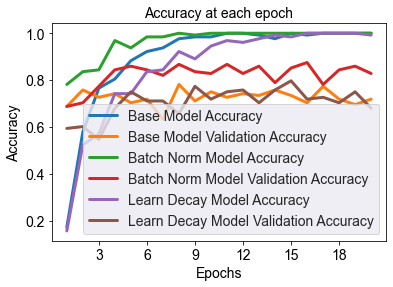

In [4]:
plt.figure(figsize=(16, 16))
fig,ax = plt.subplots()
sns.set(rc = {'figure.figsize':(6,6)})
sns.lineplot(data=df_base_mod['Accuracy'], x='Epoch', y='value', linewidth = 3, label='Base Model Accuracy')
sns.lineplot(data=df_base_mod['ValidationAccuracyEveryEpoch'], x='Epoch', y='value', linewidth = 3, label='Base Model Validation Accuracy')
sns.lineplot(data=df_batch_norm['Accuracy'], x='Epoch', y='value', linewidth = 3, label='Batch Norm Model Accuracy')
sns.lineplot(data=df_batch_norm['ValidationAccuracyEveryEpoch'], x='Epoch', y='value', linewidth = 3, label='Batch Norm Model Validation Accuracy')
sns.lineplot(data=df_learn_decay['Accuracy'], x='Epoch', y='value', linewidth = 3, label='Learn Decay Model Accuracy')
sns.lineplot(data=df_learn_decay['ValidationAccuracyEveryEpoch'], x='Epoch', y='value', linewidth = 3, label='Learn Decay Model Validation Accuracy')

fontsize = 14

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs', fontsize=fontsize)
plt.ylabel('Accuracy', fontsize=fontsize)
plt.xticks(fontsize=fontsize)

plt.yticks(fontsize=fontsize)
plt.legend(prop={'size': fontsize})
plt.title('Accuracy at each epoch', fontsize=fontsize)
# plt.savefig('baseline_model_accuracy_compare',dpi=1200)
plt.show()

<Figure size 1152x1152 with 0 Axes>

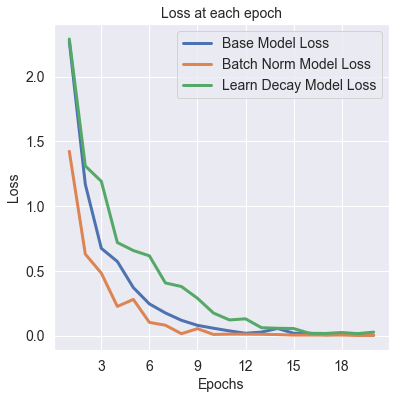

In [5]:
plt.figure(figsize=(16, 16))
fig,ax = plt.subplots()
sns.set(rc = {'figure.figsize':(6,6)})
sns.lineplot(data=df_base_mod['Loss'], x='Epoch', y='value', linewidth = 3, label='Base Model Loss')
sns.lineplot(data=df_batch_norm['Loss'], x='Epoch', y='value', linewidth = 3, label='Batch Norm Model Loss')
sns.lineplot(data=df_learn_decay['Loss'], x='Epoch', y='value', linewidth = 3, label='Learn Decay Model Loss')

fontsize = 14

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs', fontsize=fontsize)
plt.ylabel('Loss', fontsize=fontsize)
plt.xticks(fontsize=fontsize)

plt.yticks(fontsize=fontsize)
plt.legend(prop={'size': fontsize})
plt.title('Loss at each epoch', fontsize=fontsize)
# plt.savefig('baseline_model_loss_compare',dpi=1200)
plt.show()

<Figure size 1152x1152 with 0 Axes>

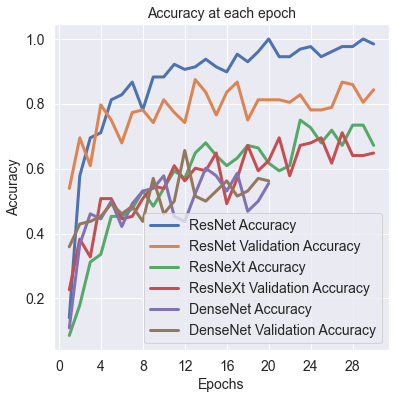

In [9]:
plt.figure(figsize=(16, 16))
fig,ax = plt.subplots()
sns.set(rc = {'figure.figsize':(6,6)})
sns.lineplot(data=df_resnet['Accuracy'], x='Epoch', y='value', linewidth = 3, label='ResNet Accuracy')
sns.lineplot(data=df_resnet['ValidationAccuracyEveryEpoch'], x='Epoch', y='value', linewidth = 3, label='ResNet Validation Accuracy')

sns.lineplot(data=df_resnext['Accuracy'], x='Epoch', y='value', linewidth = 3, label='ResNeXt Accuracy')
sns.lineplot(data=df_resnext['ValidationAccuracyEveryEpoch'], x='Epoch', y='value', linewidth = 3, label='ResNeXt Validation Accuracy')

sns.lineplot(data=df_densenet['Accuracy'], x='Epoch', y='value', linewidth = 3, label='DenseNet Accuracy')
sns.lineplot(data=df_densenet['ValidationAccuracyEveryEpoch'], x='Epoch', y='value', linewidth = 3, label='DenseNet Validation Accuracy')


fontsize = 14

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs', fontsize=fontsize)
plt.ylabel('Accuracy', fontsize=fontsize)
plt.xticks(fontsize=fontsize)

plt.yticks(fontsize=fontsize)
plt.legend(prop={'size': fontsize})
plt.title('Accuracy at each epoch', fontsize=fontsize)
plt.savefig('resnet_accuracy_compare',dpi=1200)
plt.show()

<Figure size 1152x1152 with 0 Axes>

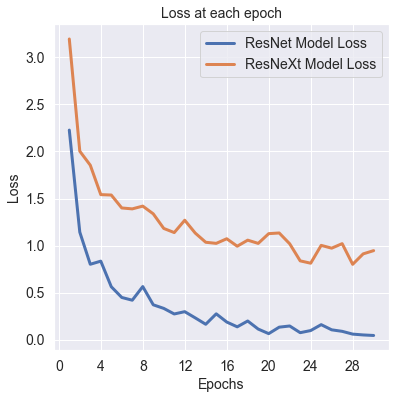

In [109]:
plt.figure(figsize=(16, 16))
fig,ax = plt.subplots()
sns.set(rc = {'figure.figsize':(6,6)})
sns.lineplot(data=df_resnet['Loss'], x='Epoch', y='value', linewidth = 3, label='ResNet Model Loss')
sns.lineplot(data=df_resnext['Loss'], x='Epoch', y='value', linewidth = 3, label='ResNeXt Model Loss')
sns.lineplot(data=df_densenet['Loss'], x='Epoch', y='value', linewidth = 3, label='DenseNet Model Loss')

fontsize = 14

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Epochs', fontsize=fontsize)
plt.ylabel('Loss', fontsize=fontsize)
plt.xticks(fontsize=fontsize)

plt.yticks(fontsize=fontsize)
plt.legend(prop={'size': fontsize})
plt.title('Loss at each epoch', fontsize=fontsize)
plt.savefig('resnet_loss_compare',dpi=1200)
plt.show()